# **GRUPO 1** - Trabajo Práctico Nuestras Caras

## **Preparar el entorno en Google Colab**

En esta sección se configura el entorno de trabajo para desarrollar el proyecto en Google Colab. Se monta Google Drive para acceder a archivos almacenados, se definen rutas base y se crean carpetas necesarias para guardar resultados, modelos o salidas del entrenamiento.

In [1]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Cargar las librerias que vamos a utilizar**

Se importan las librerías requeridas para el análisis, incluyendo herramientas para manipulación y visualización de datos, procesamiento de imágenes, reducción de dimensionalidad y evaluación de modelos. Esta etapa garantiza que el entorno cuente con todas las funcionalidades necesarias antes de iniciar el procesamiento.

In [2]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.0 MB/s eta 0:00:00


In [3]:
import sys
import os
import pickle
import cv2
import numpy as np
import polars as pl
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt


# PROYECTO_DIR = "/content/drive/MyDrive/DMA_Eigenfaces"
# SRC_DIR = os.path.join(PROYECTO_DIR, "src")
# MODELOS_DIR = os.path.join(PROYECTO_DIR, "modelos")

#sys.path.append(SRC_DIR)

!wget https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/src/procesar_imagenes.py
!wget https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/src/multiperceptron.py

from procesar_imagenes import detectar_cara_dnn, cargar_face_detector, procesar_y_crear_dataset
from multiperceptron import multiperceptron


--2025-05-05 16:45:47--  https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/src/procesar_imagenes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5787 (5.7K) [text/plain]
Saving to: ‘procesar_imagenes.py’

procesar_imagenes.p 100%[===================>]   5.65K  --.-KB/s    in 0s      

2025-05-05 16:45:47 (20.6 MB/s) - ‘procesar_imagenes.py’ saved [5787/5787]

--2025-05-05 16:45:47--  https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/src/multiperceptron.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

## **Crear directorio para cargar las imágenes**






Para cargar las fotos nuevas, se creara una carpeta en el entorno de ejecución de colab en la que se podrán arrastrar o subir las imagenes.

In [4]:
ruta_fotos = "/content/fotos_nuevas"

os.makedirs(ruta_fotos, exist_ok=True)

## **Función para procesar imágenes nuevas**

In [5]:
def procesar_imagenes_nuevas(
    input_folder: str,
    net: cv2.dnn_Net,
    img_size: Tuple[int, int] = (64, 64),
    confidence_threshold: float = 0.3
) -> pl.DataFrame:
    """
    Procesa imágenes nuevas no etiquetadas: detecta la cara, recorta, convierte a gris, resizea,
    y arma un DataFrame compatible con la red neuronal entrenada.

    Returns:
        Polars DataFrame con columnas: 'imagen' (array aplanado) y 'filename' (nombre de archivo)
    """
    imagenes = []
    nombres = []

    for file in sorted(os.listdir(input_folder)):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        path = os.path.join(input_folder, file)
        img = cv2.imread(path)
        if img is None:
            continue

        box = detectar_cara_dnn(img, net, confidence_threshold)
        if box is not None:
            x1, y1, x2, y2 = box

            # Añadir margen
            margin_ratio = 0.2
            bw, bh = x2 - x1, y2 - y1
            x1 = max(0, x1 - int(bw * margin_ratio))
            y1 = max(0, y1 - int(bh * margin_ratio))
            x2 = min(img.shape[1], x2 + int(bw * margin_ratio))
            y2 = min(img.shape[0], y2 + int(bh * margin_ratio))

            face_crop = img[y1:y2, x1:x2]
            face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
            face_crop = cv2.resize(face_crop, img_size)
            imagenes.append(face_crop.flatten())
            nombres.append(file)

    df = pl.DataFrame({
        "filename": nombres,
        **{f"x{i+1}": [img[i] for img in imagenes] for i in range(img_size[0] * img_size[1])}
    })

    return df

## **Función para graficar las fotos originales con la etiqueta asignada por el modelo**


In [6]:
def mostrar_predicciones_con_imagenes(input_folder, df_resultado, columnas=5):
    filas = (len(df_resultado) + columnas - 1) // columnas
    plt.figure(figsize=(3 * columnas, 3.5 * filas))

    for i, row in enumerate(df_resultado.iter_rows(named=True)):
        filepath = os.path.join(input_folder, row["filename"])
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(filas, columnas, i + 1)
        plt.imshow(img)
        plt.title(f'{row["pred_final"]}\n({row["confianza"]:.2f})', fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## **Cargar objetos scaler e ISOMAP**


Cargar el objeto ISOMAP utilizado para la reducción de dimensiones en el dataset original.

Descargamos los archivos scaler.pkl e isomap_9_20.pkl en una carpeta llamada modelos, ubicada en el entorno temporal de ejecución de Colab, para luego cargarlos y reutilizarlos en el preprocesamiento de nuevas imágenes.

In [9]:
# Definir carpeta de modelos
MODELOS_DIR = "/content/modelos"
os.makedirs(MODELOS_DIR, exist_ok=True)

# Descargar archivos directamente a la carpeta
!wget -P $MODELOS_DIR https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/scaler.pkl
!wget -P $MODELOS_DIR https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/isomap.pkl

# Cargar objetos
with open(os.path.join(MODELOS_DIR, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)

with open(os.path.join(MODELOS_DIR, "isomap.pkl"), "rb") as f:
    isomap = pickle.load(f)

--2025-05-05 16:46:51--  https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/scaler.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98776 (96K) [application/octet-stream]
Saving to: ‘/content/modelos/scaler.pkl.2’

scaler.pkl.2        100%[===================>]  96.46K  --.-KB/s    in 0.02s   

2025-05-05 16:46:52 (3.82 MB/s) - ‘/content/modelos/scaler.pkl.2’ saved [98776/98776]

--2025-05-05 16:46:52--  https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/isomap.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

## **Descarga de la red entrenda**

In [10]:
# Cargar e inicializar el multiperceptron

!wget -P $MODELOS_DIR https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/red.pkl

# Cargar la red
with open(os.path.join(MODELOS_DIR, "red.pkl"), "rb") as f:
    red = pickle.load(f)


--2025-05-05 16:47:00--  https://raw.githubusercontent.com/bnrey/DMA_g1_nuestras_caras/main/modelos/red.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14053 (14K) [application/octet-stream]
Saving to: ‘/content/modelos/red.pkl’

red.pkl             100%[===================>]  13.72K  --.-KB/s    in 0s      

2025-05-05 16:47:00 (40.6 MB/s) - ‘/content/modelos/red.pkl’ saved [14053/14053]



## **Inicializamos la red neuronal y cargamos el modelo ya entrado**

In [11]:
#Inicializacion de la red
mp = multiperceptron()
mp.cargar_modelo((MODELOS_DIR))

(170, np.float64(5.520267474042412e-06), np.float64(0.0))

## **Carga del modelo DNN para detección de rostros y procesamiento de las nuevas imagenes**

In [14]:
net = cargar_face_detector()

df_nuevas = procesar_imagenes_nuevas(ruta_fotos, net)

## **Creación del dataframe que se utilizará en la red neuronal**

In [15]:
# 1. Convertir imágenes nuevas a matriz
X_nuevas = np.array(df_nuevas.select([f"x{i+1}" for i in range(64*64)]))

# 2. Escalar con el scaler que guardaste
X_nuevas_scaled = scaler.transform(X_nuevas)

# 3. Aplicar ISOMAP
X_nuevas_iso = isomap.transform(X_nuevas_scaled)

# 4. Convertir a DataFrame
df_nuevas_reducidas = pl.DataFrame({
    **{f"x{i+1}": X_nuevas_iso[:, i] for i in range(X_nuevas_iso.shape[1])}
})


Añadimos una columna y con valores "?" como marcador para indicar que estas imágenes nuevas aún no tienen clase asignada. Ya que la red toma el dataframe con la clase y.

In [16]:
df_nuevas_reducidas = df_nuevas_reducidas.with_columns(
    pl.Series("y", ["?"] * df_nuevas_reducidas.height)
)

## **Predicción sobre las nuevas fotos**

In [17]:
#predecir
y_pred, y_raw, _ = mp.predecir(df_nuevas_reducidas, campos=[f"x{i+1}" for i in range(X_nuevas_iso.shape[1])], clase="y")


## **Filtrado por confianza para detectar intrusos**

Se calcula la confianza del modelo en cada predicción y se aplica un umbral (0.6).
Si la confianza es baja, la imagen se clasifica como “intruso”.
Se arma un DataFrame final con el nombre del archivo, la predicción original, la confianza y la predicción ajustada.

In [18]:
# Calculás la confianza
confianza_max = [max(vec) for vec in y_raw]

# Aplicás el umbral para detectar intrusos
umbral = 0.6
pred_final = ["intruso" if c < umbral else p for c, p in zip(confianza_max, y_pred)]

# Armás el DataFrame de resultados
df_resultado = pl.DataFrame({
    "filename": df_nuevas["filename"],
    "pred": y_pred,
    "confianza": confianza_max,
    "pred_final": pred_final
})

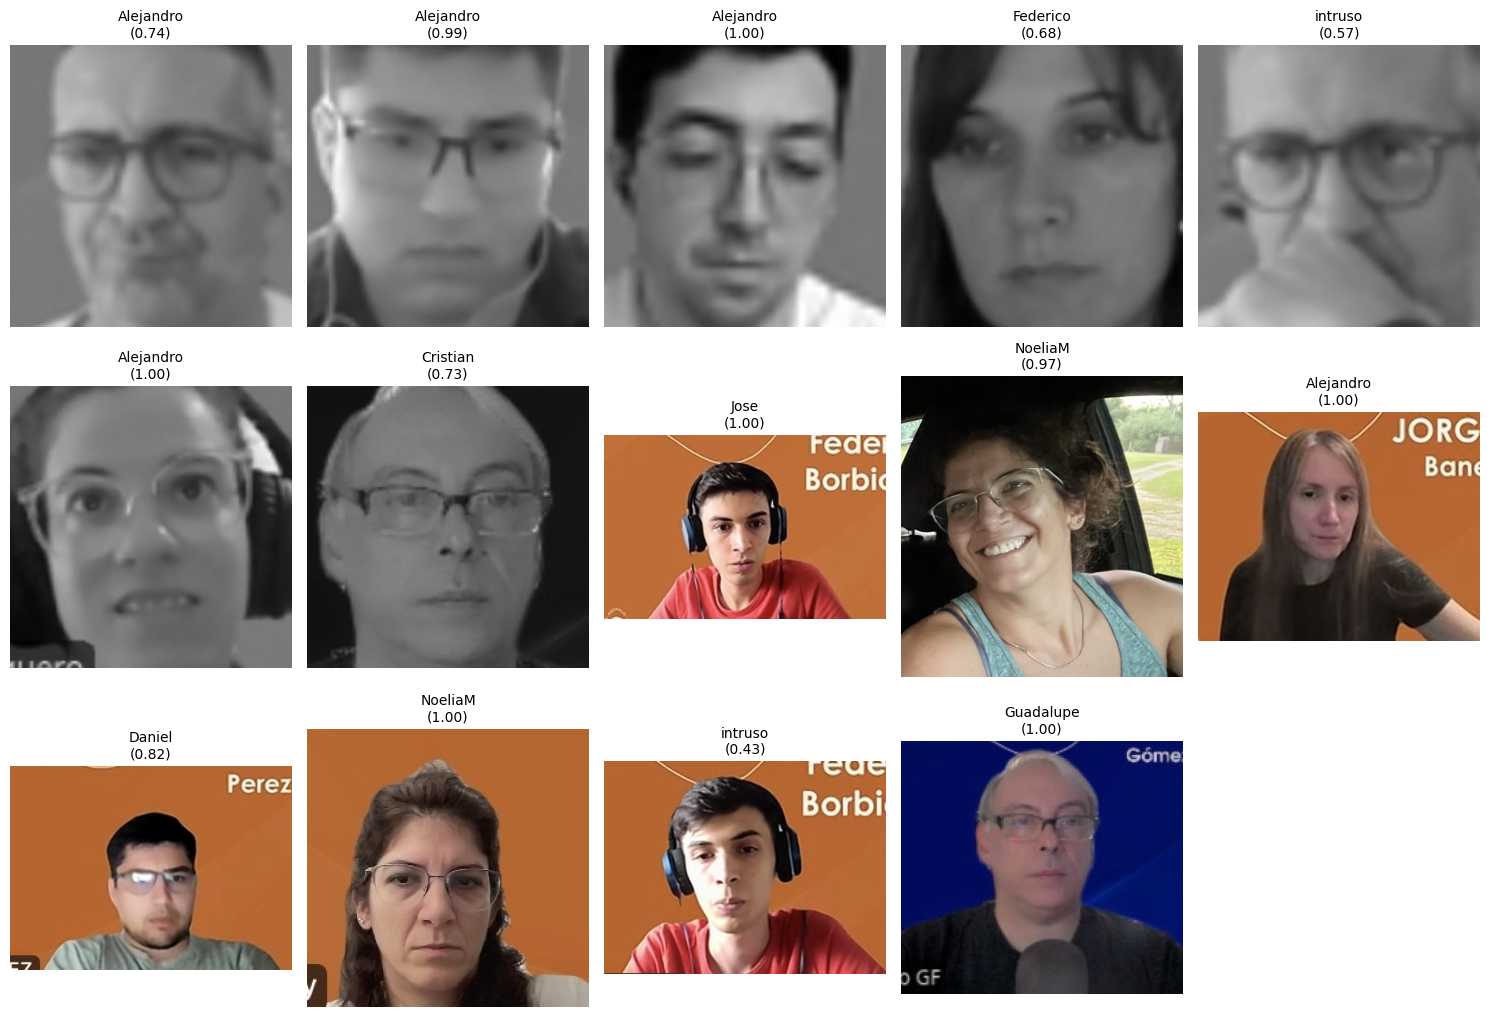

In [19]:
mostrar_predicciones_con_imagenes(ruta_fotos, df_resultado)